In [15]:
%matplotlib inline
import itertools
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('obesity/childhood-obesity-borough-filtered.csv', header=0, index_col=1)

df['Unhealthy Weight Index'] = df['Reception Overweight'] + 2 * df['Reception Obese'] + 1.5 * df['Year 6 Overweight'] + 3 * df['Year 6 Obese']
df.head()

,Local Authority,Reception Overweight,Year 6 Overweight,Reception Obese,Year 6 Obese,Unhealthy Weight Index
Year,,,,,,
2006,Barking And Dagenham,13.744655,16.269165,14.416616,20.783646,129.332571
2007,Barking And Dagenham,14.880383,16.582406,13.492823,23.913043,138.478769
2008,Barking And Dagenham,14.657837,16.060291,12.141280,24.220374,135.691957
2009,Barking And Dagenham,13.569861,15.673828,14.081931,23.583984,135.996419
2010,Barking And Dagenham,13.966858,16.996234,13.831586,24.246704,139.864494


#### Now let's see the data for Islington

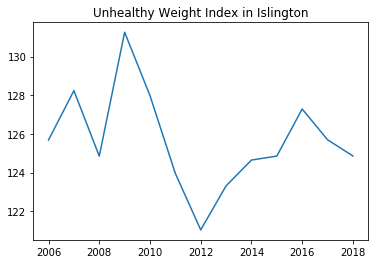

In [40]:
bor_df = df[df['Local Authority'] == 'Islington']
years = np.arange(2006, 2019)
isl_index = bor_df['Unhealthy Weight Index'].to_numpy()

plt.title('Unhealthy Weight Index in Islington')
plt.plot(years, isl_index)
plt.show()

In [70]:
sports_df = pd.read_csv('london_sports_participation.csv', header=0)

valid_bors = set(dict.fromkeys(df['Local Authority']))
valid_bors.add('City Of London')
sports_df = sports_df[sports_df['area'].isin(valid_bors)].reset_index(drop=True)

sports_df['sports_participation'].replace({
    "zero": 0,
    "one+": 1,
    "three+": 2}, inplace=True)

sports_df['year'] = sports_df['year'].apply(lambda x: int(x[:4]))
sports_df = sports_df.dropna()
sports_df = sports_df.sort_values(['area', 'year', 'sports_participation'])
sports_df


,year,area_code,area,sports_participation,percentage,population
670,2005,00AB,Barking And Dagenham,0,0.615,77100.0
10,2005,00AB,Barking And Dagenham,1,0.288,36100.0
340,2005,00AB,Barking And Dagenham,2,0.118,14800.0
671,2007,00AB,Barking And Dagenham,0,0.634,80200.0
11,2007,00AB,Barking And Dagenham,1,0.268,33900.0
...,...,...,...,...,...,...
328,2014,00BK,Westminster,1,0.440,86200.0
658,2014,00BK,Westminster,2,0.224,43900.0
989,2015,00BK,Westminster,0,0.441,90100.0
329,2015,00BK,Westminster,1,0.356,72200.0


In [68]:

mod_df = pd.DataFrame(columns=['area', 'year', 'sports_participation', 'percentage'])

for name, group in sports_df.groupby(['area', 'year']):
    if len(group) == 3:
        group.iloc[2]['percentage'] -= group.iloc[1]['percentage']
        response_rate = group['percentage'].sum()
        group['percentage'] /= response_rate
        mod_df = mod_df.append(group.loc[:, ['area', 'year', 'sports_participation', 'percentage']])
mod_df = mod_df.reset_index(drop=True)
mod_df

,area,year,sports_participation,percentage
0,Barking And Dagenham,2005,0,0.602351
1,Barking And Dagenham,2005,1,0.282076
2,Barking And Dagenham,2005,2,0.115573
3,Barking And Dagenham,2007,0,0.611969
4,Barking And Dagenham,2007,1,0.258687
...,...,...,...,...
955,Westminster,2014,1,0.393208
956,Westminster,2014,2,0.200179
957,Westminster,2015,0,0.466173
958,Westminster,2015,1,0.376321


In [56]:
sports_wm = lambda x: np.average(x, weights=[0, 1, 2])
modd_df = mod_df.loc[::3, ['area', 'year']].reset_index(drop=True)
modd_df['sports_index'] = mod_df.groupby(['area', 'year'], as_index=False).agg(sports_index=('percentage', sports_wm))
modd_df

,area,year,sports_index
0,Barking And Dagenham,2005,0.171074
1,Barking And Dagenham,2007,0.172458
2,Barking And Dagenham,2008,0.200818
3,Barking And Dagenham,2009,0.172011
4,Barking And Dagenham,2010,0.172815
...,...,...,...
315,Westminster,2011,0.278674
316,Westminster,2012,0.267318
317,Westminster,2013,0.257762
318,Westminster,2014,0.264522


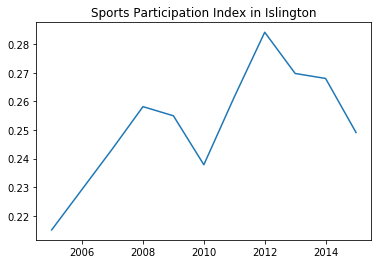

In [57]:
isl_sports = modd_df[(modd_df['area'] == 'Islington')]['sports_index'].to_numpy()
years = modd_df[(modd_df['area'] == 'Islington')]['year'].to_numpy()
plt.title('Sports Participation Index in Islington')
plt.plot(years, isl_sports)
plt.show()


In [60]:
w_df = df.reset_index().rename(columns={'Local Authority': 'area', 'Year': 'year'})
comb_df = modd_df.merge(w_df, how='inner', on=['area', 'year'])

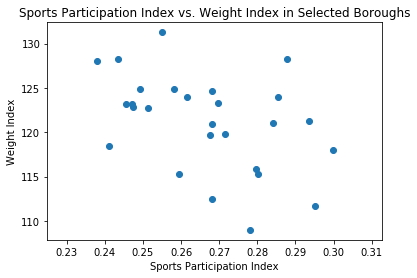

In [61]:
analysis_bors = ['Islington', 'Kensington And Chelsea', 'Camden']

weights = comb_df[comb_df['area'].isin(analysis_bors)]['Unhealthy Weight Index'].to_numpy()
sports = comb_df[comb_df['area'].isin(analysis_bors)]['sports_index'].to_numpy()

plt.title('Sports Participation Index vs. Weight Index in Selected Boroughs')
plt.xlabel('Sports Participation Index')
plt.ylabel('Weight Index')
plt.scatter(sports, weights)
plt.show()

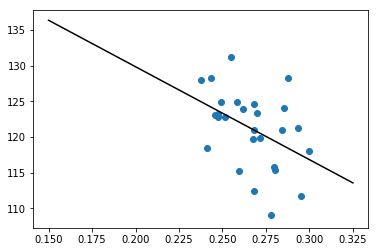

In [49]:
sports_arr = np.ones((len(sports), 2))
sports_arr[:, 0] = sports
coef = np.linalg.lstsq(sports_arr, weights)[0]

m = coef[0]
b = coef[1]
x_vals = np.array([0.15, 0.325])
plt.plot(x_vals, m * x_vals + b, 'k')
plt.scatter(sports, weights)
plt.show()

In [62]:
resids = sports_arr @ coef - weights
sum_sq = np.var(weights) * len(weights)
r_sq = 1 - sum(resids**2) / sum_sq
r_sq

0.1873294237880475

In [51]:
p_vals = {}

def do_perm_test(year_low, year_high, data):
    n_years = year_high - year_low + 1
    n_years_comp = len(data) - n_years
    test_stat = sum(data.loc[year_low:year_high, 'Unhealthy Weight Index']) / n_years \
        - sum(data.drop(index=np.arange(year_low, year_high + 1))['Unhealthy Weight Index']) / n_years_comp
    all_stats = []
    for comb in itertools.combinations(list(range(2006, 2019)), n_years):
        stat = sum(data.loc[comb, 'Unhealthy Weight Index']) / n_years \
            - sum(data.drop(index=list(comb))['Unhealthy Weight Index']) / n_years_comp
        all_stats.append(stat)
    all_stats = np.array(all_stats)
    return np.sum(all_stats <= test_stat) / len(all_stats)

for borough in valid_bors:
    bor_df = df[df['Local Authority'] == borough]
    if not bor_df.empty:
        p_vals[borough] = do_perm_test(2012, 2015, bor_df)

,NAME,p_vals
0,Kensington And Chelsea,0.071329
1,Lambeth,0.551049
2,Hammersmith And Fulham,0.106294
3,Westminster,0.514685
4,Richmond Upon Thames,0.184615


In [63]:
p_df = pd.DataFrame(list(p_vals.items()), columns=['NAME', 'p_vals']).sort_values('p_vals')
p_df

,NAME,p_vals
18,Islington,0.008392
6,Camden,0.048951
0,Kensington And Chelsea,0.071329
2,Hammersmith And Fulham,0.106294
28,Hounslow,0.120280
12,Sutton,0.131469
4,Richmond Upon Thames,0.184615
19,Wandsworth,0.194406
11,Redbridge,0.359441
5,Havering,0.390210


In [33]:
map_df = gpd.read_file('statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
map_df = map_df.sort_values('NAME').reset_index(drop=True)
upper_f = lambda x: " ".join([w[0].upper() + w[1:] for w in x.split(" ")])
map_df['NAME'] = map_df['NAME'].apply(upper_f)


In [34]:
merged = map_df.set_index('NAME').join(p_df.set_index('NAME'), how='inner')

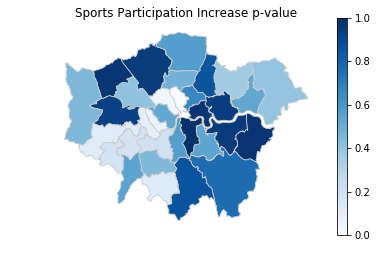

In [38]:
vmin, vmax = 0, 1
merged.plot(column='p_vals', cmap='Blues', linewidth=0.8, edgecolor='0.8')
plt.axis('off')
plt.title('Sports Participation Increase p-value')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm)
plt.show()